# Function for maximum likelihood estimation of the fitness landscape

Linear

$\int_{0}^{0.5} \frac{\theta}{f(1-2f)} \exp(-\frac{f}{\phi(1-2f)}) \,df$

$l = \log(f)$

$f = e^l$

$\frac{df}{dl} = e^l$

$df = e^l dl$

Log scale

$\int \frac{\theta}{e^l(1-2e^l)} \exp(-\frac{e^l}{\phi(1-2e^l)}) e^l \,dl$

$\int \frac{\theta}{1-2e^l} \exp(-\frac{e^l}{\phi(1-2e^l)}) \,dl$

with $\phi = \frac{e^{st} -1}{2N\tau s}$, $\theta = 2N\tau\mu$



In [1]:
# Install the required packages
%pip install pandas numpy scipy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
from utils.support import mutation_rates_list_variants_gene, geneConfig
import pandas as pd
import numpy as np
import scipy
from scipy import integrate
import math
import matplotlib.pyplot as plt
import matplotlib
import pickle

# Load data for DNMT3A

In [3]:
print(
    mutation_rates_list_variants_gene(
        [882, "R882C"],
        geneConfig["DNMT3A"]["gene_exons"],
        geneConfig["DNMT3A"]["gene_exons_extra_bases"],
        geneConfig["DNMT3A"]["intron_triplets"],
    )  # 1.41512e-08
)
print(
    mutation_rates_list_variants_gene(
        [882, "R882H"],
        geneConfig["DNMT3A"]["gene_exons"],
        geneConfig["DNMT3A"]["gene_exons_extra_bases"],
        geneConfig["DNMT3A"]["intron_triplets"],
    )  # 1.88229e-08
)

1.41512e-08
1.88229e-08


In [4]:
allDataDict = {}

dataFile = "Inputs/allData_mutFitness.csv"
data = pd.read_csv(dataFile)
allDataDict["UKB"] = data

data

,dataName,subsetName,value,subsetValue,pop,study
0,DNMT3A_R882[HC],g_CHEK2,0.15710,1,3300,UKB
1,DNMT3A_R882[HC],g_CHEK2,0.27125,1,3300,UKB
2,DNMT3A_R882[HC],g_CHEK2,0.31305,1,3300,UKB
3,DNMT3A_R882[HC],g_CHEK2,0.23055,1,3300,UKB
4,DNMT3A_R882[HC],g_CHEK2,0.17490,1,3300,UKB
...,...,...,...,...,...,...
560,DNMT3A_R882[HC],g_CHEK2,0.13135,0,352796,UKB
561,DNMT3A_R882[HC],g_CHEK2,0.19590,0,352796,UKB
562,DNMT3A_R882[HC],g_CHEK2,0.27490,0,352796,UKB
563,DNMT3A_R882[HC],g_CHEK2,0.18135,0,352796,UKB


# Method

## Optimization function

In [5]:
def logProbtheory_ages_mut_inc(l, params):  # = predicted density (i.e. normalised by 2 x mu)
    "Natural log of the probability of observing a variant within a specific binwidth if able to sequence perfectly"
    N = 9.40166610e04  # N inferred from DNMT3A R882H (see notebook 'parameter estimation using MLE (DNMT3A R882H etc)')
    sigma = 8.0651  # update to UKBB data
    s = params[0]
    mean = 57.05282  # update to UKBB data

    total_density = integrate.quad(
        lambda t: (
            N
            / (1 - 2 * np.exp(l))
            * np.exp(-((np.exp(l)) / (((np.exp(s * t) - 1) / (2 * N * s)) * (1 - 2 * np.exp(l)))))
        )
        * ((1 / ((2 * np.pi * (sigma) ** 2) ** 0.5)) * (np.exp(-((t - mean) ** 2) / (2 * (sigma**2))))),
        mean - 2 * sigma,
        mean + 2 * sigma,
    )

    if total_density[0] <= 0:
        return np.nan

    return np.log(total_density[0])


def logProbDataGivenModel_ages_mut_inc(params, data):
    "This returns the natural log likelihood of the entire data, in specified binwidths, for a given theta and phi"
    total_square_distance = 0
    count = 0
    mutRateInc = params[1]
    for datapoint in data:
        if np.exp(datapoint[0]) < 0.5:
            logfreq = datapoint[0]
            predicted_log_density = logProbtheory_ages_mut_inc(logfreq, params)
            if np.isnan(predicted_log_density):
                continue
            actual_density = np.exp(datapoint[1])
            actual_density_mut_inc = actual_density / mutRateInc
            if actual_density_mut_inc > 0:
                actual_log_density_mut_inc = np.log(actual_density_mut_inc)
                square_distance = (actual_log_density_mut_inc - predicted_log_density) ** 2
                total_square_distance = total_square_distance + square_distance
                count += 1
    if mutRateInc < 0:
        total_square_distance = 1e6

    return total_square_distance / count if count > 0 else 1e6

## Data generation and run optimization function

In [6]:
def filterData(data, config, key):
    keyConfig = config[key]
    filteredData = data.copy()

    # Remove NaN in dataCol
    filteredData = filteredData[filteredData["dataName"] == keyConfig["dataName"]]
    filteredData = filteredData[filteredData["subsetName"] == keyConfig["subsetName"]]

    if "subsetValue" in keyConfig:
        filteredData = filteredData[filteredData["subsetValue"] == keyConfig["subsetValue"]]

    filteredData.reset_index(inplace=True, drop=True)

    return filteredData


def generateNormedData(vafList, variantMutationRate, pop, numBins=25):
    normedValue = pop * 2 * variantMutationRate

    logVafList = np.log(vafList)
    hist, binEdges = np.histogram(logVafList, bins=numBins)

    widths = np.diff(binEdges)
    binCenters = (binEdges[:-1] + binEdges[1:]) / 2
    normedHist = hist / (normedValue * widths)

    zipData = list(zip(binCenters, normedHist))
    zipData = [x for x in zipData if x[1] > 0]  # remove 0s
    zipData = [[x[0], math.log(x[1])] for x in zipData]  # log transform

    return zipData


def runOptimization(allDataDict, numBins, config, key):
    zipData = []
    for cohort in config[key]["pop"]:
        data = allDataDict[cohort]
        filteredData = filterData(data, config, key)
        vafList = filteredData["value"].tolist()
        print(f"{cohort=}, {key=}, mean VAF = {np.mean(vafList)}, std VAF = {np.std(vafList)}")
        tmpZipData = generateNormedData(
            vafList, config[key]["variantMutationRate"], config[key]["pop"][cohort], numBins=numBins
        )
        zipData.extend(tmpZipData)
    initialGuess = [0.1, 1]
    result = scipy.optimize.minimize(
        logProbDataGivenModel_ages_mut_inc, initialGuess, args=(zipData), method="Nelder-Mead"
    )
    return result, zipData


def generatePermutedData(data, config, key):
    keyConfig = config[key]
    filteredData = data.copy()

    # Remove NaN in dataCol
    filteredData = filteredData[filteredData["dataName"] == keyConfig["dataName"]]
    filteredData = filteredData[filteredData["subsetName"] == keyConfig["subsetName"]]

    # Calculate ratio of 0s and 1s
    ratioZero = filteredData["subsetValue"].value_counts(normalize=True)[0]
    ratioOne = filteredData["subsetValue"].value_counts(normalize=True)[1]

    if keyConfig["subsetValue"] == 0:
        # select random data with ratioZero
        randIndex = np.random.choice(filteredData.index, size=int(len(filteredData) * ratioZero), replace=False)
    else:
        # select random data with ratioOne
        randIndex = np.random.choice(filteredData.index, size=int(len(filteredData) * ratioOne), replace=False)
    filteredData = filteredData.loc[randIndex]

    filteredData.reset_index(inplace=True, drop=True)

    return filteredData


import multiprocessing as mp


def runOptimizationSingle(zipData):
    initialGuess = [0.1, 1]
    result = scipy.optimize.minimize(
        logProbDataGivenModel_ages_mut_inc, initialGuess, args=(zipData), method="Nelder-Mead"
    )
    return result


def runPermutedOptimization(data, numBins, config, key, numPermutations=100):
    allZipData = []

    for i in range(numPermutations):
        np.random.seed(i)
        zipData = []
        for cohort in config[key]["pop"]:
            data = allDataDict[cohort]
            permutedData = generatePermutedData(data, config, key)
            vafList = permutedData["value"].tolist()
            tmpZipData = generateNormedData(
                vafList, config[key]["variantMutationRate"], config[key]["pop"][cohort], numBins=numBins
            )
            zipData.extend(tmpZipData)
        allZipData.append(zipData)

    with mp.Pool(32) as pool:
        results = pool.starmap(runOptimizationSingle, [(zipData,) for zipData in allZipData])

    return results, allZipData

## Generate the fitness landscape and plot

In [7]:
r882HcMutRate = mutation_rates_list_variants_gene(
    (882, "R882H"),
    geneConfig["DNMT3A"]["gene_exons"],
    geneConfig["DNMT3A"]["gene_exons_extra_bases"],
    geneConfig["DNMT3A"]["intron_triplets"],
)
numBins = 50
# numBins = 'doane'

config = {
    "R882[HC]_gCHEK2": {
        "dataName": "DNMT3A_R882[HC]",
        "pop": {"UKB": 3300},
        "subsetName": "g_CHEK2",
        "subsetValue": 1,
        "variantMutationRate": r882HcMutRate,
    },
    "R882[HC]_no_gCHEK2": {
        "dataName": "DNMT3A_R882[HC]",
        "pop": {"UKB": 352796},
        "subsetName": "g_CHEK2",
        "subsetValue": 0,
        "variantMutationRate": r882HcMutRate,
    },
}
import time

allResults = {}
for key in config.keys():
    startTime = time.time()
    print(f"{key}:")
    result, zipData = runOptimization(allDataDict, numBins, config, key)
    minResult = result.x  # [s, mutRateInc]
    minLoss = result.fun

    print(f"    s = {minResult[0]*100:.2f}, mutRateInc = {minResult[1]:.2e}, result = {minLoss:.2f}")
    print(f"    Time taken = {time.time() - startTime:.2f}s")

    allResults[key] = {
        "s": minResult[0],
        "mutRateInc": minResult[1],
        "loss": logProbDataGivenModel_ages_mut_inc(minResult, zipData),
        "allResults": result,
        "data": zipData,
    }
pickle.dump(allResults, open("allResults.pickle", "wb"))

R882[HC]_gCHEK2:
cohort='UKB', key='R882[HC]_gCHEK2', mean VAF = 0.21283124999999997, std VAF = 0.07310137198396142
    s = 20.14, mutRateInc = 2.88e+00, result = 0.04
    Time taken = 0.41s
R882[HC]_no_gCHEK2:
cohort='UKB', key='R882[HC]_no_gCHEK2', mean VAF = 0.20402613843351547, std VAF = 0.09294338707577558
    s = 18.18, mutRateInc = 1.75e-01, result = 0.72
    Time taken = 0.65s


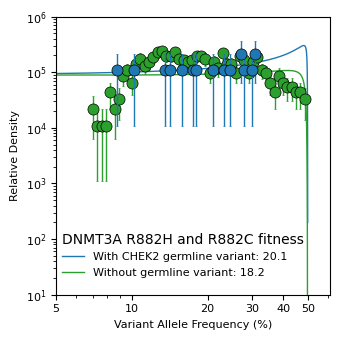

In [8]:
title = {"R882[HC]_gCHEK2": "With CHEK2 germline variant", "R882[HC]_no_gCHEK2": "Without germline variant"}
# Create main figure with len(allResults) subplots
nCol = 2
keyToPlot = [k for k in allResults.keys() if "gCHEK2" in k]
nRow = int(np.ceil(len(keyToPlot) / nCol))
N = 9.40166610e04
c_size = 1
c_thick = 1.0
e_width = 1.0


def generatePointData(key, numBins=25):
    all_bin_centres, all_normalised_hist, all_lowerErrorList, all_upperErrorList = [], [], [], []
    for cohort in config[key]["pop"]:
        data = allDataDict[cohort]
        filteredData = filterData(data, config, key)
        vafList = filteredData["value"].tolist()
        vafList = [x for x in vafList if x <= 0.5]
        normed_value = config[key]["pop"][cohort] * 2 * config[key]["variantMutationRate"] * res["mutRateInc"]

        logVafList = np.log(vafList)
        hist, binEdges = np.histogram(logVafList, bins=numBins)

        widths = np.diff(binEdges)
        bin_centres = (binEdges[:-1] + binEdges[1:]) / 2
        normalised_hist = hist / (normed_value * widths)

        bin_centres = np.exp(bin_centres) * 100

        lowerErrorList = []
        upperErrorList = []
        for h, normH in zip(hist, normalised_hist):
            if h == 1:
                lowerError = 0.9
                upperError = 1
            else:
                lowerError = upperError = np.sqrt(h)
            lowerError = lowerError / (normed_value * widths[0])
            upperError = upperError / (normed_value * widths[0])
            lowerErrorList.append(lowerError)
            upperErrorList.append(upperError)

        all_bin_centres.extend(bin_centres)
        all_normalised_hist.extend(normalised_hist)
        all_lowerErrorList.extend(lowerErrorList)
        all_upperErrorList.extend(upperErrorList)

    return all_bin_centres, all_normalised_hist, all_lowerErrorList, all_upperErrorList


allLinePlot = {}
for i, key in enumerate(keyToPlot):
    res = allResults[key]
    x = np.linspace(1e-2, 0.5 - 1e-6, 1000)
    x = np.log(x)
    y = [np.exp(logProbtheory_ages_mut_inc(l, [res["s"]])) for l in x]
    x = np.exp(x) * 100

    row, col = int(i / nCol), i % nCol

    allLinePlot[key] = {"x": x, "y": y}

allLegend = []
fig, ax = plt.subplots()
# set size
fig.set_size_inches(6, 6)

# Plot y axis in log scale
ax.set_xscale("log")
ax.set_xticks([5, 10, 20, 30, 40, 50])
ax.set_xticklabels([5, 10, 20, 30, 40, 50])
ax.set_xlabel("Variant Allele Frequency (%)")
ax.set_yscale("log")
ax.set_ylabel("Relative Density")
lineColorSaved = {}
for key in [key for key in allResults.keys() if "gCHEK2" in key]:
    pointData = allLinePlot[key]
    res = allResults[key]
    x, y = pointData["x"], pointData["y"]
    s = res["s"]

    ax.plot(x, y, linewidth=e_width)
    allLegend.append(f"{title[key]}: {s*100:.1f}")

    bin_centres, normalised_hist, lowerErrorList, upperErrorList = generatePointData(key, numBins)

    # get color of the line
    lineColor = ax.get_lines()[-1].get_color()
    lineColorSaved[key] = lineColor
    ax.errorbar(
        bin_centres,
        normalised_hist,
        yerr=[lowerErrorList, upperErrorList],
        fmt="o",
        elinewidth=e_width,
        ecolor=lineColor,
        capsize=c_size,
        capthick=c_thick,
        markersize=8,
        markeredgewidth=0.5,
        markeredgecolor="k",
        markerfacecolor=lineColor,
        zorder=10 if "no_gCHEK2" in key else 20,
    )
ax.set_ylim(bottom=10, top=1e6)
ax.set_xlim(left=5)
# add legend
fig.legend(
    allLegend,
    bbox_to_anchor=(0.91, 0.35),
    title="DNMT3A R882H and R882C fitness",
    frameon=False,
    alignment="left",
    fontsize=8,
)

fig.set_tight_layout(True)

# Set the font size and font family
plt.rcParams["font.family"] = "sans-serif"
fig.set_size_inches(3.5, 3.5)
# Set font size for the figure
for item in [ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels():
    item.set_fontsize(8)
    
plt.show()
fig.savefig("Figures/E3.pdf", format="pdf", dpi=300, bbox_inches="tight")

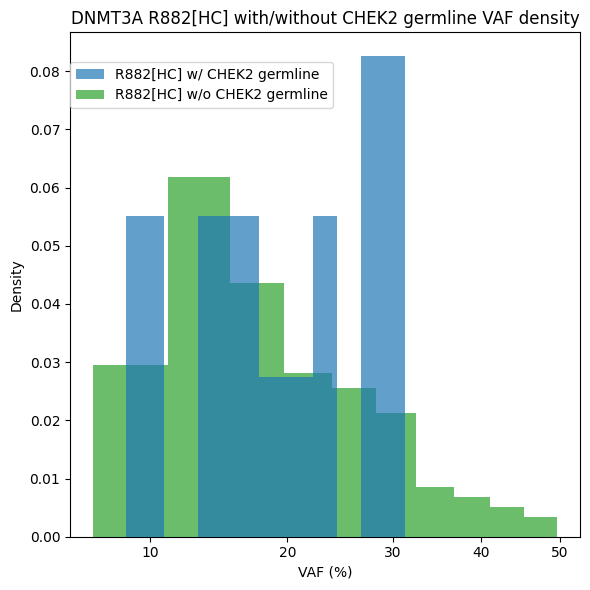

In [9]:
title = {"R882[HC]_gCHEK2": "R882[HC] w/ CHEK2 germline", "R882[HC]_no_gCHEK2": "R882[HC] w/o CHEK2 germline"}
# Create main figure with len(allResults) subplots
nCol = 2
keyToPlot = [k for k in allResults.keys() if "gCHEK2" in k]
allLegend = []
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)

ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# set sqrt scale for x axis
ax.set_xscale("function", functions=(lambda x: np.sqrt(x), lambda x: x**2))
ax.set_xlabel("VAF (%)")
ax.set_ylabel("Density")
for i, key in enumerate(keyToPlot):
    filteredData = filterData(data, config, key)
    vafList = filteredData["value"].tolist()
    toPlot = [x * 100 for x in vafList if x <= 0.5]

    ax.hist(toPlot, density=True, color=lineColorSaved[key], alpha=0.7, zorder=10 if "no_gCHEK2" in key else 20)
    allLegend.append(f"{title[key]}")
    # break

ax.set_title("DNMT3A R882[HC] with/without CHEK2 germline VAF density")
fig.legend(allLegend, bbox_to_anchor=(0.575, 0.9))
fig.set_tight_layout(True)

plt.show()
# fig.savefig("Figures/densityByVafHist.pdf", format="pdf", dpi=300)

## Permutaion and plot

In [10]:
import time

allPermutedResults = {}
numPermutations = 1000
for key in config.keys():
    startTime = time.time()
    print(f"{key}:")
    results, allZipData = runPermutedOptimization(data, numBins, config, key, numPermutations)
    allS = [result.x[0] for result in results]
    # Remove outliners
    iqrS = scipy.stats.iqr(allS)
    q1S = np.quantile(allS, 0.25)
    q3S = np.quantile(allS, 0.75)
    keepIdx = [i for i, x in enumerate(allS) if (x >= q1S - 1.5 * iqrS) and (x <= q3S + 1.5 * iqrS)]
    results = [results[i] for i in keepIdx]
    allZipData = [allZipData[i] for i in keepIdx]
    print(f"    {len(results)} results kept, removing {numPermutations - len(results)} results")

    allLoss = [result.fun for result in results]
    allS = [result.x[0] for result in results]
    allMutRateInc = [result.x[1] for result in results]

    print(
        f"    s range = {min(allS)*100:.2f} - {max(allS)*100:.2f}, mutRateInc range = {min(allMutRateInc):.2e} - {max(allMutRateInc):.2e}, loss range = {min(allLoss):.2f} - {max(allLoss):.2f}"
    )
    print(
        f"    s mean = {np.mean(allS)*100:.2f}, mutRateInc mean = {np.mean(allMutRateInc):.2e}, loss mean = {np.mean(allLoss):.2f}"
    )
    print(
        f"    s std = {np.std(allS)*100:.2f}, mutRateInc std = {np.std(allMutRateInc):.2e}, loss std = {np.std(allLoss):.2f}"
    )
    print(f"    Time taken = {time.time() - startTime:.2f}s")

    allPermutedResults[key] = {
        "s": minResult[0],
        "mutRateInc": minResult[1],
        "loss": minLoss,
        "allS": allS,
        "allMutRateInc": allMutRateInc,
        "allLoss": allLoss,
        "allResults": results,
        "data": allZipData,
    }
pickle.dump(allPermutedResults, open("allPermutedResults.pickle", "wb"))

R882[HC]_gCHEK2:
    840 results kept, removing 160 results
    s range = 16.03 - 20.29, mutRateInc range = 2.10e+00 - 1.00e+01, loss range = 0.00 - 0.25
    s mean = 17.76, mutRateInc mean = 3.63e+00, loss mean = 0.06
    s std = 0.66, mutRateInc std = 7.76e-01, loss std = 0.04
    Time taken = 55.50s
R882[HC]_no_gCHEK2:
    833 results kept, removing 167 results
    s range = 18.10 - 18.21, mutRateInc range = 1.71e-01 - 1.89e-01, loss range = 0.60 - 0.79
    s mean = 18.16, mutRateInc mean = 1.76e-01, loss mean = 0.71
    s std = 0.02, mutRateInc std = 3.24e-03, loss std = 0.03
    Time taken = 124.50s


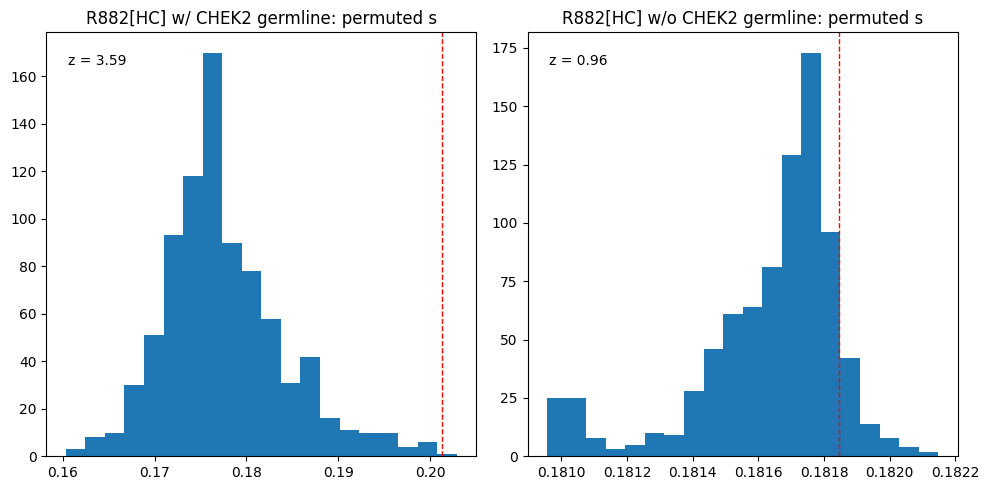

In [11]:
allPermutedResults = pickle.load(open("allPermutedResults.pickle", "rb"))
title = {"R882[HC]_gCHEK2": "R882[HC] w/ CHEK2 germline", "R882[HC]_no_gCHEK2": "R882[HC] w/o CHEK2 germline"}
# Plot hist for s and mutRateInc
plt.figure(figsize=(10, 5))
keyToPlot = [k for k in allPermutedResults.keys() if "gCHEK2" in k]
for i, key in enumerate(keyToPlot):
    plt.subplot(1, len(keyToPlot), i + 1)
    plt.hist(allPermutedResults[key]["allS"], density=False, bins=20)
    plt.title(f"{title[key]}: permuted s")
    # line at true data result
    plt.axvline(allResults[key]["s"], color="r", linestyle="dashed", linewidth=1)
    # add z score of true data result with respect to permuted data
    zScore = (allResults[key]["s"] - np.mean(allPermutedResults[key]["allS"])) / np.std(allPermutedResults[key]["allS"])
    plt.text(0.05, 0.95, f"z = {zScore:.2f}", transform=plt.gca().transAxes, va="top")
plt.tight_layout()
plt.show()
# plt.savefig("Figures/sPermuted.pdf", format="pdf", dpi=300)